In [1]:
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rcParams["figure.figsize"] = (20,10)

def plot_quantile_compare1(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            y.append(float(line.split()[1]))
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("t(s)")
    plt.plot(x,y,'.',color='c')
    plt.show()
    
def plot_quantile_compare2(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            y.append(float(line.split()[2]))
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("GF/s")
    plt.plot(x,y,'.',color='c')
    #plt.show()
    
    
def plot_quantile_compare_perf1(log):
    with open(log) as f:
        lines = f.readlines()
        x = []
        y = []
        for line in lines:
            x.append(float(line.split()[0]))
            time = float(line.split()[1])
            cost = float(line.split()[2])
            y.append((cost/time)*1e-9)
            

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("size")
    plt.ylabel("GF/s")
    plt.plot(x,y,'.',color='c')
    plt.show()

### Visualizing the dataset

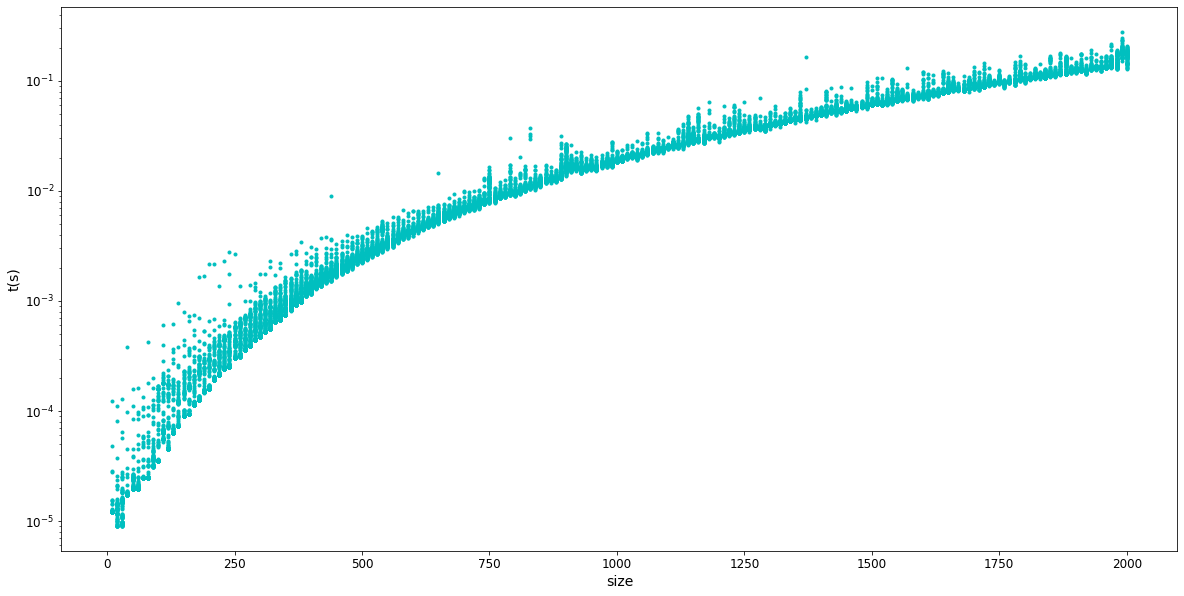

In [5]:
plt.yscale('log')
plot_quantile_compare1("data/gemm2000.txt")

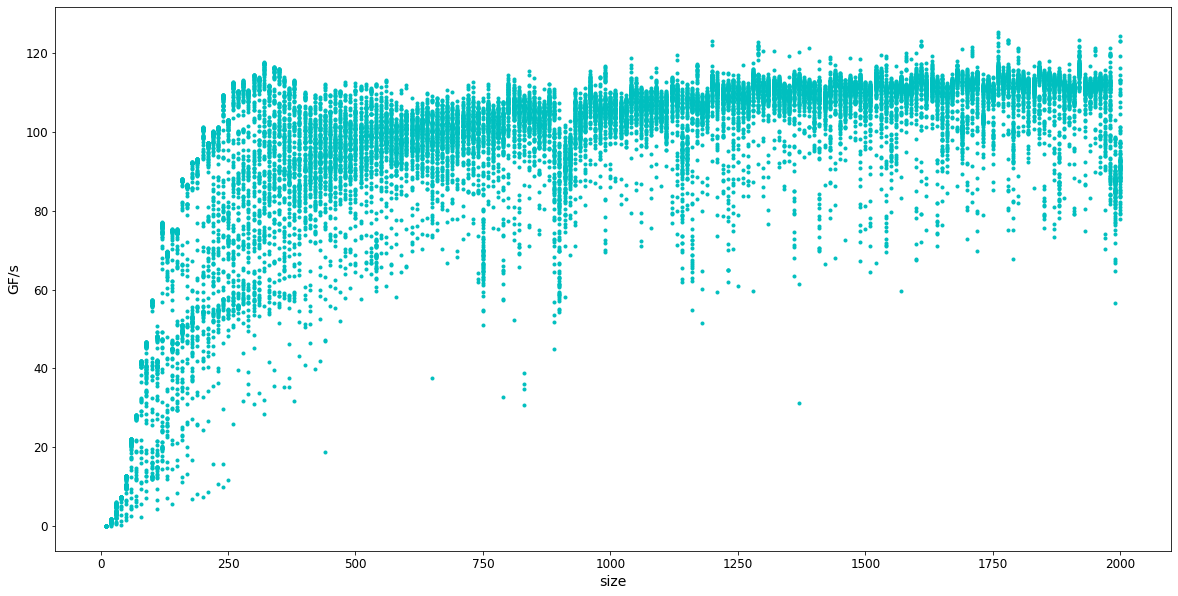

In [6]:
plot_quantile_compare_perf1("data/gemm2000.txt")

### Shuffle dataset

In [65]:
import random

def shuffle_data(log):
    fw = open(log.split(".")[0] + "_shuffled.txt", "w")
    with open(log) as f:
        lines = f.readlines()
        random.shuffle(lines)
        for line in lines:
            fw.write(line)
    fw.close()

In [66]:
shuffle_data("data/gemm2000.txt")

### tf.data API

In [11]:
def cast_to_number(x):
    return tf.strings.to_number(x,out_type=tf.float64)

def split_features_labels(x):
    nn_input = x[0]
    nn_gt = x[2]
    return (nn_input[...,tf.newaxis], nn_gt[...,tf.newaxis])

In [12]:
#filename = "data/gemm2000_shuffled.txt"
filename = "data/gemm2000_shuffled_timeperf_std.txt"
ds_file = tf.data.TextLineDataset(filename)
ds_file = ds_file.map(tf.strings.split)
ds_file = ds_file.map(cast_to_number)
ds_file = ds_file.map(split_features_labels)

### Splitting dataset

In [5]:
DATASET_SIZE = len(open(filename).readlines())

In [6]:
DATASET_SIZE

20000

In [7]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.10 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)

train_dataset = ds_file.take(train_size)
test_dataset = ds_file.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

**Iterator**

In [8]:
train_dataset = train_dataset.batch(5)
it = iter(train_dataset)

**Sample point**

In [9]:
x = next(it)
x

(<tf.Tensor: id=120, shape=(5, 1), dtype=float64, numpy=
 array([[1370.],
        [ 580.],
        [ 970.],
        [1550.],
        [1620.]])>, <tf.Tensor: id=121, shape=(5, 1), dtype=float64, numpy=
 array([[0.46376611],
        [0.00382433],
        [0.34930906],
        [0.54793242],
        [0.60669791]])>)

### Neural Network

>$f = W_2\phi(W_1x)$

In [7]:
QUANTILES = [0.15,0.5,0.85]

tf.keras.backend.set_floatx('float64')

class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.00), input_shape=(None,))
    self.d2 = tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.00))
    self.d3 = tf.keras.layers.Dense(64, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.00))
    self.d4 = tf.keras.layers.Dense(len(QUANTILES), activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.00))

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    return self.d4(x)

# Create an instance of the model
model = MyModel()

In [11]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.RMSprop(0.001)

In [12]:
input_x, gt_y = next(it)

In [13]:
with tf.GradientTape() as tape:
    nn_out = model(input_x)
    loss_out = loss(gt_y, nn_out) 
    gradients = tape.gradient(loss_out, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [14]:
input_x, gt_y, nn_out, loss_out

(<tf.Tensor: id=122, shape=(5, 1), dtype=float64, numpy=
 array([[ 910.],
        [1910.],
        [ 430.],
        [1520.],
        [1300.]])>, <tf.Tensor: id=123, shape=(5, 1), dtype=float64, numpy=
 array([[-0.26915176],
        [ 0.62746457],
        [ 0.00488368],
        [ 0.71046927],
        [ 0.65906098]])>, <tf.Tensor: id=229, shape=(5, 3), dtype=float64, numpy=
 array([[-0.04203085,  0.07562347,  1.97062771],
        [-0.04238547,  0.10437523,  1.97340217],
        [-0.00705729,  0.02797169,  1.96581971],
        [-0.04371661,  0.09913869,  1.97214951],
        [-0.04434578,  0.09369645,  1.97133081]])>, <tf.Tensor: id=251, shape=(), dtype=float64, numpy=1.1091806888580322>)

In [175]:
len(gradients) ## W!, B1, W2, B2

4

In [32]:
test_dataset = test_dataset.batch(1)
it_test = iter(test_dataset)

In [33]:
a,b = next(it_test)

In [34]:
a

<tf.Tensor: id=12432, shape=(1, 2), dtype=float64, numpy=array([[1.2400e+03, 1.5376e+06]])>

In [35]:
nn_out = model(a)

In [36]:
nn_out

<tf.Tensor: id=12443, shape=(1, 1), dtype=float64, numpy=array([[0.]])>

### Wrap up

In [66]:
@tf.function
def multi_quantile_loss(quantiles,y,f):
    e = (y-f)
    loss = 0
    for k in range(len(quantiles)):
        q = quantiles[k]
        loss += tf.keras.backend.mean(q*e[:,k] + tf.keras.backend.clip(-e[:,k],tf.keras.backend.epsilon(),np.inf))
    return loss

In [67]:
model = MyModel()
#loss = tf.keras.losses.MeanAbsoluteError()
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.RMSprop(lr_schedule)
#optimizer = tf.keras.optimizers.Adam()
mean_loss = tf.keras.metrics.Mean(name='mean_loss')

@tf.function
def train_step(x,gt):
    with tf.GradientTape() as tape:
        nn_out = model(x)
        loss_out = multi_quantile_loss(QUANTILES,gt, nn_out) 
        reg_loss = tf.math.add_n(model.losses)
        loss_out = loss_out + reg_loss
    gradients = tape.gradient(loss_out, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    mean_loss(loss_out)

In [68]:
def train_model():
    i = 0
    for input_x, gt_y in train_dataset:
        i = i+1
        train_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss.result()))
            mean_loss.reset_states()

In [73]:

train_model()

Iter 100, Loss: 0.33660017007511145
Iter 200, Loss: 0.3643086357687568
Iter 300, Loss: 0.3971942254436644
Iter 400, Loss: 0.39786142732156304
Iter 500, Loss: 0.35949289694197356
Iter 600, Loss: 0.3838856983923867
Iter 700, Loss: 0.3643057128551275
Iter 800, Loss: 0.35548271177861446
Iter 900, Loss: 0.39015287842883817
Iter 1000, Loss: 0.38200814817448203
Iter 1100, Loss: 0.3885244883660258
Iter 1200, Loss: 0.3690245727334338
Iter 1300, Loss: 0.3842520721056598
Iter 1400, Loss: 0.34869090484534987
Iter 1500, Loss: 0.4032555216060446
Iter 1600, Loss: 0.3456309589218332
Iter 1700, Loss: 0.33412303753370226
Iter 1800, Loss: 0.3497640372048994
Iter 1900, Loss: 0.3720888181131212
Iter 2000, Loss: 0.3591016019033406
Iter 2100, Loss: 0.36471693131411514
Iter 2200, Loss: 0.3403679355960071
Iter 2300, Loss: 0.35822760903147727
Iter 2400, Loss: 0.38727756924688167
Iter 2500, Loss: 0.3805349070132745
Iter 2600, Loss: 0.35022709450728073
Iter 2700, Loss: 0.38641604867582985
Iter 2800, Loss: 0.35830

In [29]:
mean_loss_test = tf.keras.metrics.Mean(name='mean_loss_test')

@tf.function
def test_step(x, gt):
    nn_out = model(x)
    test_loss = quantile_loss(QUANTILE,gt, nn_out)

    mean_loss_test(test_loss)
    
    return nn_out

In [30]:
def test_model():
    i = 0
    for input_x, gt_y in test_dataset:
        i = i+1
        result = test_step(input_x, gt_y)
        if(i%100 == 0):
            template = 'Iter {}, Loss: {}'
            print(template.format(i,mean_loss_test.result()))
            print(input_x.numpy(), result.numpy(), gt_y.numpy())
        mean_loss_test.reset_states()

In [37]:
test_model()

Iter 100, Loss: 119.79499816894531
[[   830. 688900.]] [[0.]] [[119.795]]
Iter 200, Loss: 340.4159851074219
[[1.2200e+03 1.4884e+06]] [[0.]] [[340.416]]
Iter 300, Loss: 61.887001037597656
[[   680. 462400.]] [[0.]] [[61.887]]
Iter 400, Loss: 42.472999572753906
[[   590. 348100.]] [[0.]] [[42.473]]
Iter 500, Loss: 84.2249984741211
[[   760. 577600.]] [[0.]] [[84.225]]
Iter 600, Loss: 732.8790283203125
[[1.5900e+03 2.5281e+06]] [[0.]] [[732.879]]
Iter 700, Loss: 491.5
[[1.4300e+03 2.0449e+06]] [[0.]] [[491.5]]
Iter 800, Loss: 1.2380000352859497
[[  120. 14400.]] [[0.]] [[1.238]]
Iter 900, Loss: 449.5570068359375
[[1.3400e+03 1.7956e+06]] [[0.]] [[449.557]]
Iter 1000, Loss: 167.1580047607422
[[   990. 980100.]] [[0.]] [[167.158]]
Iter 1100, Loss: 409.7349853515625
[[1.30e+03 1.69e+06]] [[0.]] [[409.735]]
Iter 1200, Loss: 641.7940063476562
[[1.2500e+03 1.5625e+06]] [[0.]] [[641.794]]
Iter 1300, Loss: 1129.0419921875
[[1.8300e+03 3.3489e+06]] [[0.]] [[1129.042]]
Iter 1400, Loss: 252.1990051

### Eval

In [8]:
def get_quantile_gt(filename,quantile):
    data = {}
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            try:
                data[float(line.split()[0])].append(float(line.split()[2]))
            except KeyError:
                data[float(line.split()[0])] = []
                data[float(line.split()[0])].append(float(line.split()[2]))

    for k,v in data.items():
        v.sort()
        
    x_q = []
    y_q = []
    q = int(quantile*100)
    for k,v in data.items():
        x_q.append(k)
        y_q.append(v[q])
        
    return (x_q,y_q)

In [13]:
x_q1, y_q1 = get_quantile_gt(filename,QUANTILES[0])
x_q2, y_q2 = get_quantile_gt(filename,QUANTILES[1])
x_q3, y_q3 = get_quantile_gt(filename,QUANTILES[2])

In [14]:
model.load_weights('./checkpoints/chp_gemm_square')

In [15]:
eval_size = 250
inp = tf.constant(eval_size,shape=(1,1),dtype="float64")
out = model(inp)

In [16]:
out

<tf.Tensor: id=273, shape=(1, 3), dtype=float64, numpy=array([[-1.35914754, -0.49946015,  0.1496822 ]])>

In [17]:
import numpy as np

In [18]:
sizes = np.arange(10,2110,5)

In [19]:
y = []
for s in sizes:
    inp = tf.constant(s,shape=(1,1),dtype="float64")
    y.append((model(inp).numpy()).reshape(-1))
y = np.array(y)

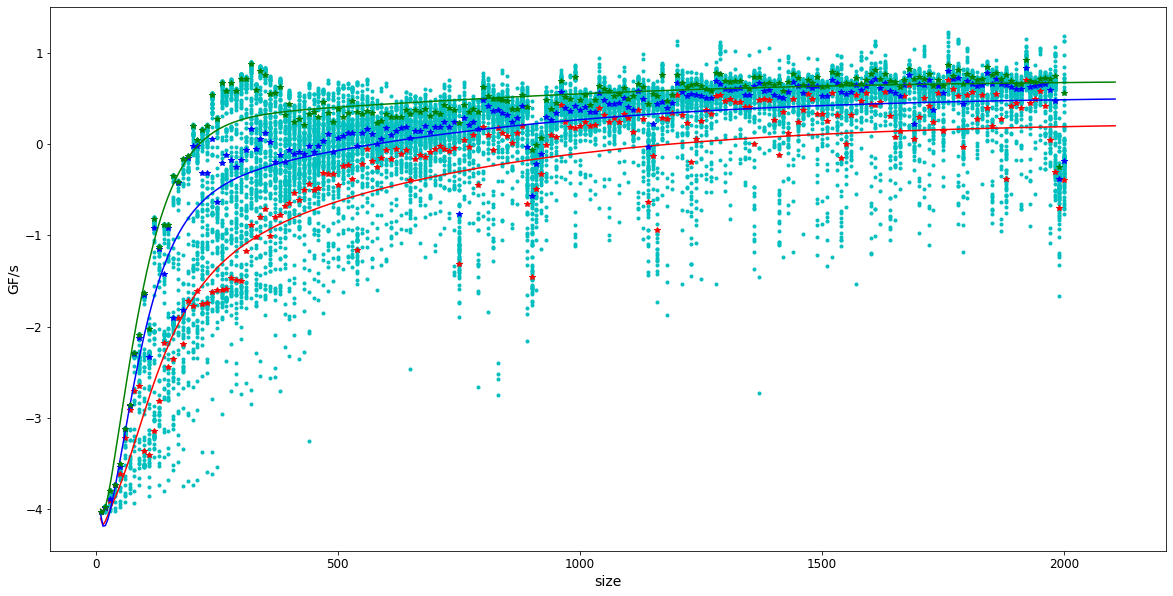

In [20]:
#plt.yscale('log')
plot_quantile_compare2("data/gemm2000_shuffled_timeperf_std.txt")
plt.plot(sizes,y[:,0],color='r')
plt.plot(x_q1,y_q1,'*',color='r')
plt.plot(sizes,y[:,1],color='b')
plt.plot(x_q2,y_q2,'*',color='b')
plt.plot(sizes,y[:,2],color='g')
plt.plot(x_q3,y_q3,'*',color='g')
plt.show()

In [61]:
model.losses

[<tf.Tensor: id=76714, shape=(), dtype=float64, numpy=0.0014421830303465472>,
 <tf.Tensor: id=76722, shape=(), dtype=float64, numpy=0.08558598350079252>,
 <tf.Tensor: id=76730, shape=(), dtype=float64, numpy=0.013166614328004722>]

In [60]:
model.d1.get_weights()

[array([[ 0.0391185 ,  0.07489408,  0.00955415,  0.04121713,  0.04902671,
         -0.01903614, -0.08652303,  0.03212332, -0.00156229, -0.04064424,
          0.00134866,  0.04788559, -0.07253152,  0.01191795,  0.05095224,
          0.09170064,  0.02336713, -0.03497435, -0.00143155,  0.09374009,
         -0.08130883,  0.06990394,  0.02351211, -0.07315359, -0.0200955 ,
          0.00356623,  0.05524848,  0.06423154,  0.00475602, -0.00169657,
          0.07638708,  0.00564956,  0.00153587,  0.01357016, -0.02123212,
          0.05343552,  0.00193306, -0.07996823,  0.01466364, -0.0113572 ,
         -0.04066657, -0.05863961,  0.0525175 , -0.07724095,  0.00845512,
          0.03498058, -0.02012329,  0.00894144,  0.03105336,  0.01251317,
         -0.05991903, -0.08503895,  0.03353598, -0.00361193, -0.00581489,
         -0.00597891,  0.01354368, -0.08245462, -0.01878637,  0.05864049,
          0.08582565,  0.0699049 , -0.01303581,  0.00462505]]),
 array([-0.06335281,  0.05748295,  0.07319406,  

In [64]:
filename

'data/gemm2000_shuffled_timeperf_std.txt'

In [76]:
model.summary()

Model: "my_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             multiple                  512       
_________________________________________________________________
dense_25 (Dense)             multiple                  32896     
_________________________________________________________________
dense_26 (Dense)             multiple                  8256      
_________________________________________________________________
dense_27 (Dense)             multiple                  195       
Total params: 41,859
Trainable params: 41,859
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.save_weights('./checkpoints/chp_gemm_square')